In [ ]:
############################
# 0.000000 0.000000 1.000000 0.000000
# -0.099504 0.000000 0.995037 -0.995037
# -0.010000 0.000000 0.999950 0.000000

### PCA

In [ ]:
# http://pdfviewer.softgateon.net/?file=http://pdi.topografia.upm.es/an_dom/Doctorado/lidaryestrobusta.pdf
# https://stackoverflow.com/questions/38754668/plane-fitting-in-a-3d-point-cloud/38770513#38770513

In [94]:
import numpy as np

data = np.loadtxt("./input.txt", skiprows=2)
f = open("input.txt")
p = float(f.readline().strip())
n = int(f.readline().strip())
size_road = 0.5 # Половина принадлежит точкам дороги
threshold = n * size_road

def find_abcd(data):
    data_mean = data - np.mean(data, axis=0)
    # Матрица ковариации
    matrix = np.cov(data_mean.T) 
    eigenvalues, eigenvectors = np.linalg.eig(matrix)

    sort = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[sort]
    eigenvectors = eigenvectors[:, sort]
    
    # Нормаль к плоскости - последний собственный вектор
    normal = eigenvectors[:, 2]
    point = np.mean(data, axis=0)

    a, b, c = normal
    d = -(np.dot(normal, point))
    
    return [np.round(i, 6) for i in [a, b, c, d]]

def optimaze(data, a, b, c, d):
    # Смотрим есть ли точки с разными знаками (разные классы)
    target = data.dot([a, b, c])
    more_idx, more_p = [], []
    less_idx, less_p = [], []
    for i, val in enumerate(target):
        # Если отклонение не больше чем p
        if val <= p:
            less_idx.append(i)
            less_p.append(val)
        else:
            more_idx.append(i)
            more_p.append(val)
  
    if len(more_p) > 0 and len(less_p) > 0:
        # Если есть разные знаки, то больший класс относим к дороге. Остальные выкидываем   
        if len(more_p) >= len(less_p):
            road_idx = more_idx
            road = more_p
        else:
            road_idx = less_idx
            road = less_p

        # Ищем параметры плоскости дороги еще раз
        a, b, c, d = find_abcd(data[road_idx, :])
        target_new = data[road_idx, :].dot([a, b, c])
        
        # Разделяем на классы дальше, если они находятся, 
        # так как плоскость усредняется по всем точкам, а препятствие может быть высоким
        is_need_optimize = np.unique(target_new > p, return_counts=True)
        if len(is_need_optimize[0]) > 1 and len(data[road_idx, :]) > threshold:
            return optimaze(data[road_idx, :], a, b, c, d)
        else:
            return a, b, c, d        
    else:
        # Если нет, то отдаем что было
        return a, b, c, d

coefs = find_abcd(data)
a, b, c, d = optimaze(data, *coefs)

print(a, b, c, d)

0.0 0.0 1.0 -0.0


### RANSAC

In [ ]:
# https://github.com/falcondai/py-ransac

-0.0077185527212106225 -0.016185930785649946 -0.9976629165607239 0.06593287880899901


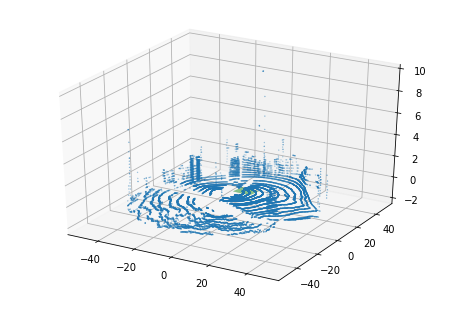

In [33]:
import numpy as np
import random 
# import matplotlib
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d

def run_ransac(data, estimate, is_inlier, sample_size, goal_inliers, max_iterations, stop_at_goal=True, random_seed=None):
    best_ic = 0
    best_model = None
    random.seed(random_seed)
    data = list(data)
    for i in range(max_iterations):
        s = random.sample(data, int(sample_size))
        m = estimate(s)
        ic = 0
        for j in range(len(data)):
            if is_inlier(m, data[j]):
                ic += 1

        if ic > best_ic:
            best_ic = ic
            best_model = m
            if ic > goal_inliers and stop_at_goal:
                break
#     print('took iterations:', i+1, 'best model:', best_model, 'explains:', best_ic)
    return best_model, best_ic

def augment(xyzs):
    axyz = np.ones((len(xyzs), 4))
    axyz[:, :3] = xyzs
    return axyz

def estimate(xyzs):
    axyz = augment(xyzs[:3])
    return np.linalg.svd(axyz)[-1][-1, :]

def is_inlier(coeffs, xyz, threshold):
    return np.abs(coeffs.dot(augment([xyz]).T)) < threshold

def plot_plane(a, b, c, d):
    xx, yy = np.mgrid[:10, :10]
    return xx, yy, (-d - a * xx - b * yy) / c

if __name__ == '__main__':
    xyzs = np.loadtxt("input4.txt",skiprows=2)
    f = open("input4.txt")
    p = float(f.readline().strip())
    n = int(f.readline().strip())
    
    max_iterations = 100
    goal_inliers = n * 0.5 # половина точек принадлежит плоскости

    m, b = run_ransac(xyzs, estimate, lambda x, y: is_inlier(x, y, p), 3, goal_inliers, max_iterations)
    a, b, c, d = m
    print(a, b, c, d)
    
    fig = plt.figure()
    ax = mplot3d.Axes3D(fig)
    ax.scatter3D(xyzs.T[0], xyzs.T[1], xyzs.T[2], s=0.1)
    xx, yy, zz = plot_plane(a, b, c, d)
    ax.plot_surface(xx, yy, zz, color=(0, 1, 0, 0.5))
    plt.show()